In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from helpFunctions import *
import os
import warnings
warnings.filterwarnings('ignore')
%pylab inline
%load_ext autoreload
%autoreload 2
matplotlib.rcParams['figure.figsize'] = [20, 8]
plt.rcParams.update({'font.size': 16})
years, data, varNamesOverYears, varNamesOverYearsPlus = loadData()

Populating the interactive namespace from numpy and matplotlib


In [2]:
# important variables
'''
    2002-2022 quarterly data
    "TOTAL ASSETS",
    "TOTAL EQUITY CAPITAL",
    "TOTAL LIABILITIES AND MINORITY INTEREST",
    "TOTAL DEPOSITS",
    "FEDERAL FUNDS SOLD", # short term borrowing
    "FEDERAL FUNDS PURCHASED IN DOMESTIC OFFICES", # short term lending
'''
importantVars = ["TOTAL ASSETS",
    "TOTAL EQUITY CAPITAL",
    "TOTAL LIABILITIES AND MINORITY INTEREST",
    "TOTAL DEPOSITS",
    "FEDERAL FUNDS SOLD",
    "SECURITIES SOLD UNDER AGREEMENTS TO REPURCHASE",
    "FEDERAL FUNDS PURCHASED IN DOMESTIC OFFICES",
    "SECURITIES PURCHASED UNDER AGREEMENTS TO RESELL",
    "NONINTEREST-BEARING BALANCES AND CURRENCY AND COIN",
    "LOANS AND LEASES; NET OF UNEARNED INCOME - TOTALS",
    "PROVISION FOR LOAN AND LEASE LOSSES",
    "UNDIVIDED PROFITS AND CAPITAL RESERVES",
    "COMMON STOCK"
    ]
names = ["bank", "date", "assets", "equity", "liabilities", "deposit", "overnightLending","shortBorrowing","overnightBorrowing","shortLending", "cash","loan","provision","reserveUndividedProfit","stock"]
    

In [3]:
# process all important variables in one big table
varTable = pd.DataFrame()
for year in years[1:]:
    df = pd.DataFrame()
    for var in importantVars:
        if var == "PROVISION FOR LOAN AND LEASE LOSSES" and year >=2019:
            _, d = call(["Provision for loan and lease losses"], year, data = data, varNamesOverYears=varNamesOverYearsPlus) 
            d.rename(columns = {"Provision for loan and lease losses": var}, inplace = True)
        else:
            _, d = call([var], year, data = data, varNamesOverYears=varNamesOverYearsPlus)
        if df.size == 0:
            df = d
        else:
            df[var] = d[var]
    if varTable.size == 0:
        varTable = df
    else:
        varTable = pd.concat([varTable, df], axis = 0)

varTable.columns = names
varTable['date'] = pd.to_datetime(varTable['date'])

# clean some data points 
varTable = varTable[(varTable['assets'] >0) & 
                    (varTable['equity'] >0) & 
                    (varTable['liabilities'] >0) & 
                    (varTable['deposit'] >=0) & 
                    (varTable['overnightLending'] >=0) & 
                    (varTable['shortLending'] >=0) & 
                    (varTable['overnightBorrowing'] >=0) &
                    (varTable['shortBorrowing'] >=0)
]
varTable.shape

(572034, 15)

In [4]:
varTable["year"] = varTable.date.dt.year
varTable["leverage"] = varTable.assets/varTable.equity
varTable["borrowing"] = varTable.shortBorrowing + varTable.overnightBorrowing
ds = (varTable.assets/varTable.equity)
varYear = varTable[ds.between(0, ds.quantile(.99), inclusive=True)]
varYear.head()

,bank,date,assets,equity,liabilities,deposit,overnightLending,shortBorrowing,overnightBorrowing,shortLending,cash,loan,provision,reserveUndividedProfit,stock,year,leverage,borrowing
0,BANK OF HANCOCK COUNTY,2002-12-31,74327.0,12561.0,61766.0,61501.0,7808,0.0,0,0.0,1833.0,40263.0,180,8861.0,1200.0,2002,5.917284,0.0
1,FIRST COMMUNITY BANK XENIA-FLORA,2002-12-31,25737.0,3856.0,21881.0,20614.0,943,0.0,0,0.0,650.0,18351.0,17,3501.0,120.0,2002,6.674533,0.0
2,"MINEOLA COMMUNITY BANK, SSB",2002-12-31,132091.0,17188.0,114903.0,77842.0,4190,0.0,0,0.0,1652.0,28675.0,31,16627.0,0.0,2002,7.685071,0.0
3,BISON STATE BANK,2002-12-31,8408.0,1248.0,7160.0,7054.0,33,0.0,0,0.0,87.0,4494.0,18,644.0,25.0,2002,6.737179,0.0
4,PEOPLES BANK,2002-12-31,150496.0,16944.0,133552.0,132029.0,3990,0.0,0,0.0,8615.0,106299.0,500,9597.0,596.0,2002,8.881964,0.0


In [5]:
varYear.sort_values("assets", ascending=False)

,bank,date,assets,equity,liabilities,deposit,overnightLending,shortBorrowing,overnightBorrowing,shortLending,cash,loan,provision,reserveUndividedProfit,stock,year,leverage,borrowing
17651,"JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",2022-03-31,3.476711e+09,299153000.0,3.177537e+09,2.635021e+09,0,152256000.0,620000,447187000.0,25718000.0,1.052041e+09,1456000,188805000.0,2028000.0,2022,11.621849,152876000.0
12808,"JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",2022-06-30,3.380824e+09,297245000.0,3.083483e+09,2.548727e+09,19000,142838000.0,1339000,438283000.0,26768000.0,1.086451e+09,2557000,192717000.0,2028000.0,2022,11.373863,144177000.0
7998,"JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",2022-09-30,3.308575e+09,297265000.0,3.011246e+09,2.502364e+09,14000,134598000.0,1492000,433351000.0,24140000.0,1.098028e+09,4083000,198025000.0,2028000.0,2022,11.130052,136090000.0
3304,"JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",2021-12-31,3.306982e+09,302848000.0,3.004113e+09,2.549631e+09,67000,121179000.0,1769000,386506000.0,25657000.0,1.043968e+09,-9296000,182421000.0,2028000.0,2021,10.919610,122948000.0
8235,"JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",2021-09-30,3.290398e+09,296062000.0,2.994316e+09,2.499413e+09,0,138482000.0,2213000,376160000.0,25252000.0,1.006985e+09,-8009000,174198000.0,2028000.0,2021,11.113882,140695000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16503,"FIRST TRUST COMPANY OF ONAGA, NATIONAL ASSOCIA...",2002-09-30,6.650000e+02,616.0,4.900000e+01,0.000000e+00,0,0.0,0,0.0,166.0,0.000000e+00,0,-384.0,500.0,2002,1.079545,0.0
20726,MOUNT GILEAD SAVINGS AND LOAN ASSOCIATION,2014-03-31,3.200000e+02,304.0,1.600000e+01,1.100000e+01,0,0.0,0,0.0,234.0,0.000000e+00,0,303.0,0.0,2014,1.052632,0.0
24080,MONADNOCK COMMUNITY BANK,2013-03-31,2.000000e+02,107.0,9.300000e+01,0.000000e+00,0,0.0,0,0.0,125.0,0.000000e+00,0,-100.0,0.0,2013,1.869159,0.0
4971,"CAMBRIDGE APPLETON TRUST, N.A.",2017-12-31,2.000000e+02,100.0,1.000000e+02,0.000000e+00,0,0.0,0,0.0,200.0,0.000000e+00,0,0.0,0.0,2017,2.000000,0.0


In [6]:
varYear.groupby("year")["leverage"].describe()

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
2002,33840.0,10.147159,3.014843,1.000490,8.284306,10.386151,12.166560,22.044923
2003,33294.0,10.095471,2.986438,1.000604,8.291856,10.314930,12.086403,22.026572
2004,32671.0,10.025332,2.985165,1.000600,8.257486,10.259555,12.002042,22.022873
2005,32115.0,9.974325,3.036227,1.000753,8.158044,10.231737,11.963308,22.036125
2006,31715.0,9.847136,3.163937,1.000373,7.971851,10.113874,11.904934,21.977851
2007,31167.0,9.593020,3.107610,1.000690,7.761326,9.864331,11.634787,22.019250
2008,30536.0,9.719540,3.059477,1.000262,7.933661,9.956585,11.700521,21.970283
2009,29082.0,9.972975,3.015055,1.000074,8.191429,10.068529,11.727322,22.029388
2010,27745.0,9.897720,2.869661,1.000092,8.239683,9.947502,11.460143,22.048153


<AxesSubplot:title={'center':'Signature Bank'}, xlabel='date'>

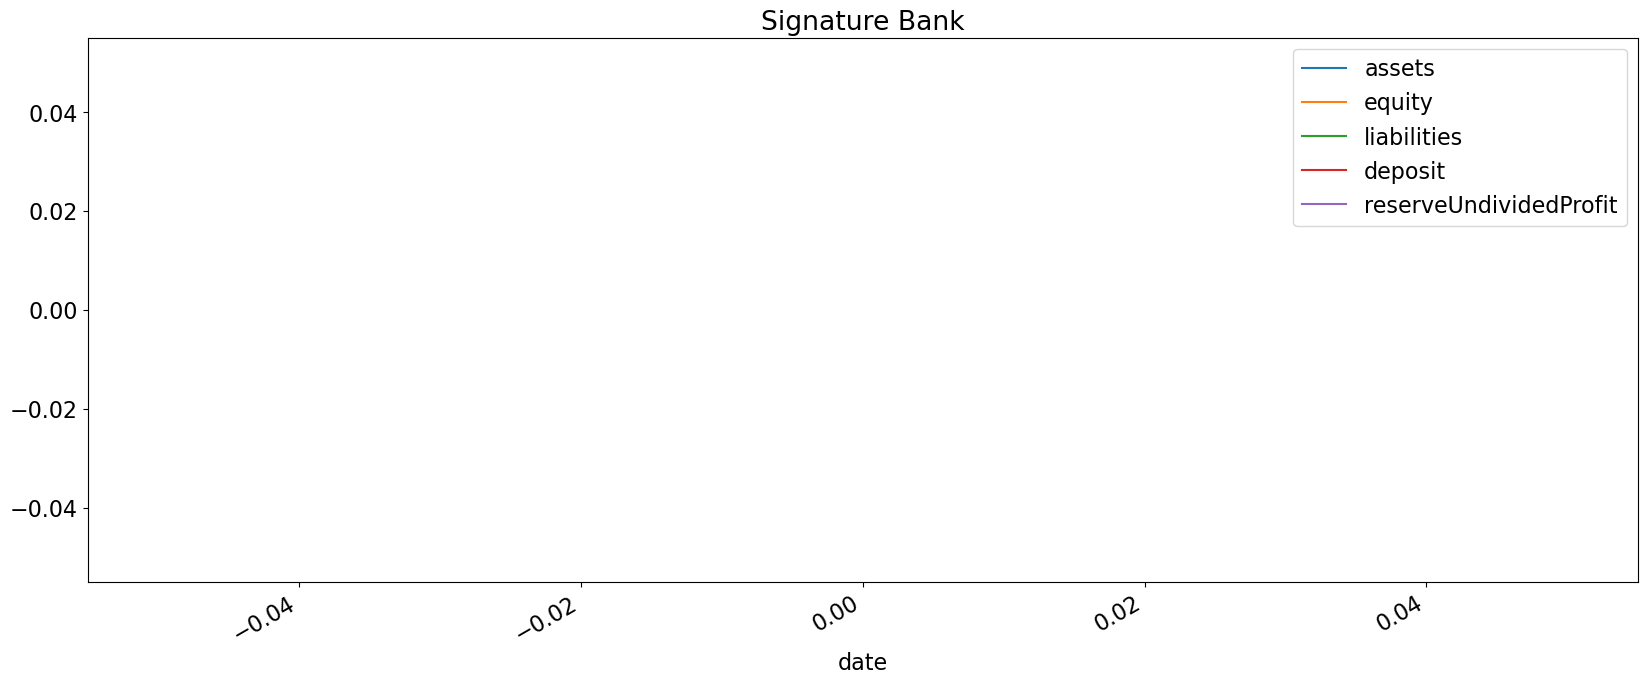

In [7]:
CRED = varTable[varTable.bank == "CREDIT SWISS"].groupby("date").mean()
SIG.plot(y=["assets","equity","liabilities","deposit","reserveUndividedProfit"], title = "Signature Bank")

<AxesSubplot:title={'center':'Signature Bank'}, xlabel='date'>

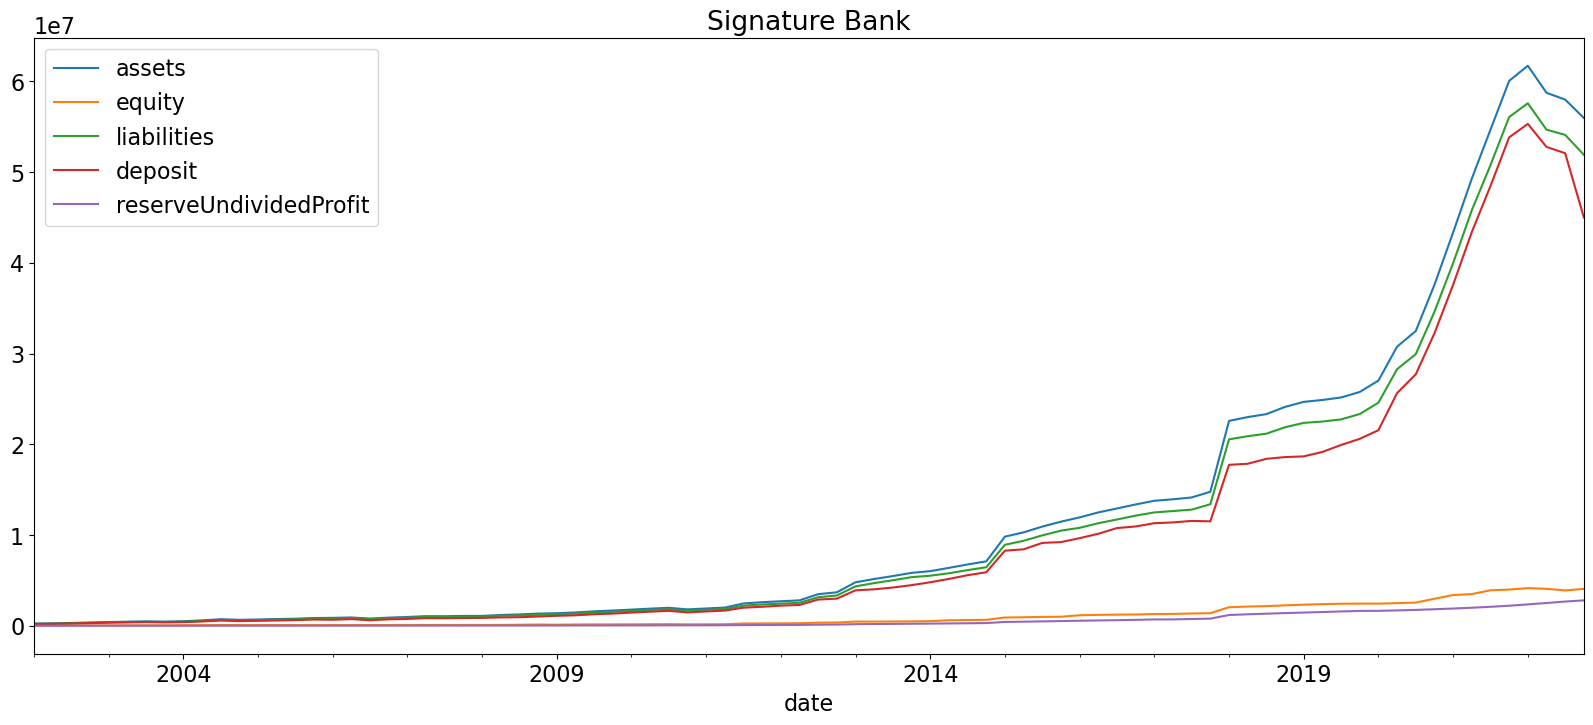

In [39]:
SIG = varTable[varTable.bank == "SIGNATURE BANK"].groupby("date").mean()
SIG.plot(y=["assets","equity","liabilities","deposit","reserveUndividedProfit"], title = "Signature Bank")

<AxesSubplot:title={'center':'Silicon Valley Bank'}, xlabel='date'>

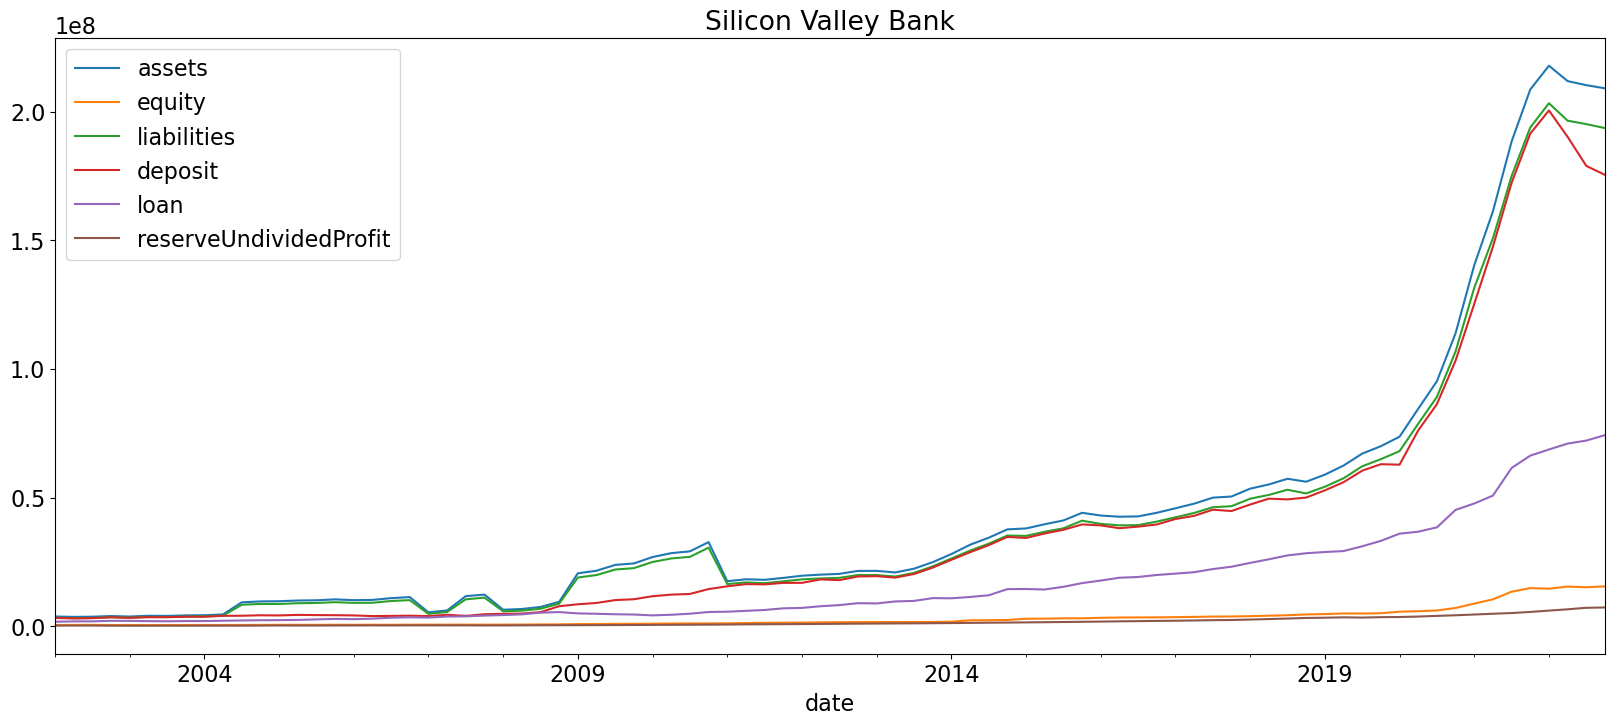

In [40]:
SVB = varTable[varTable.bank == "SILICON VALLEY BANK"].groupby("date").mean()
SVB.plot(y=["assets","equity","liabilities","deposit","reserveUndividedProfit"], title="Silicon Valley Bank")

<AxesSubplot:title={'center':'JPMorgan Chase Bank'}, xlabel='date'>

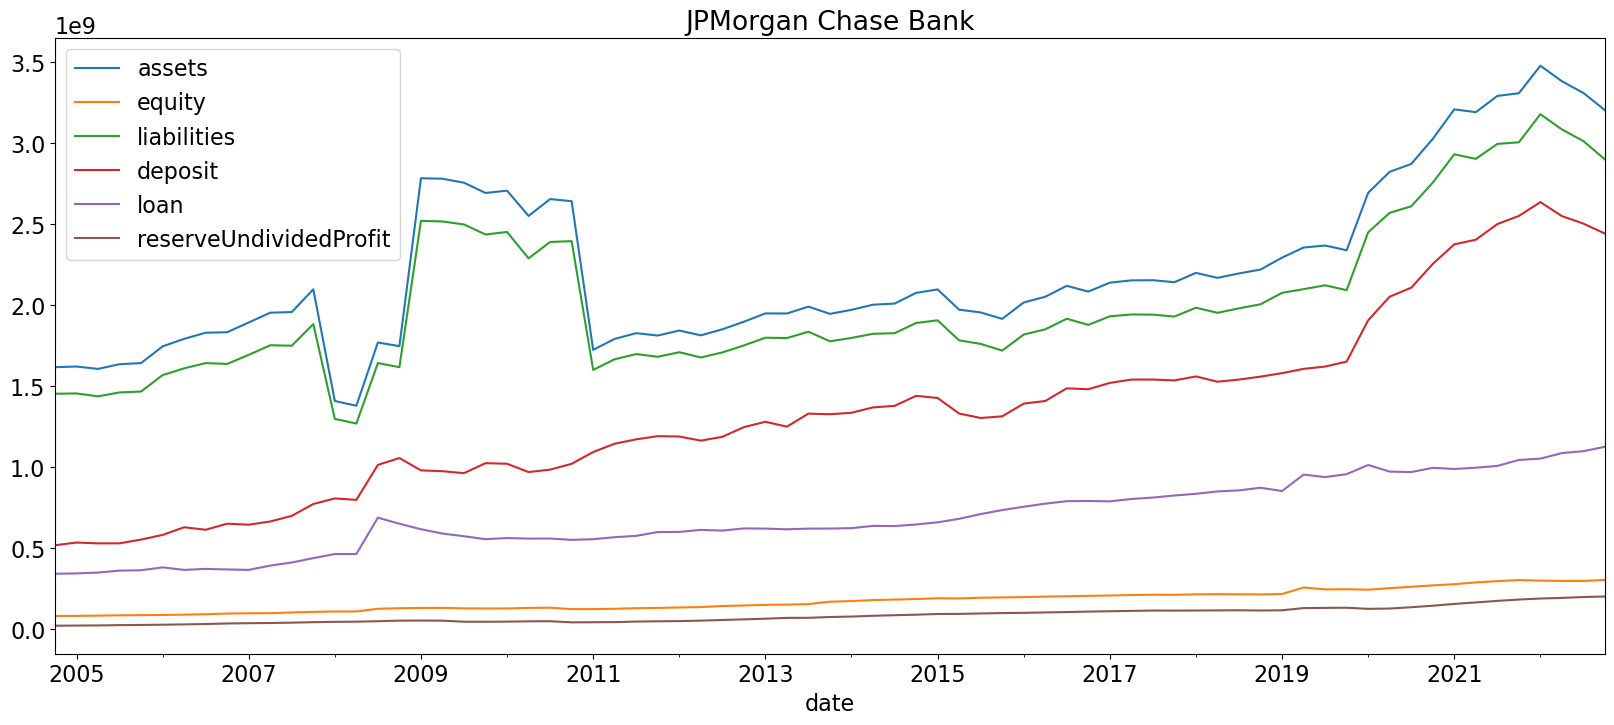

In [41]:
JPM = varTable[varTable.bank == "JPMORGAN CHASE BANK, NATIONAL ASSOCIATION"].groupby("date").mean()
JPM.plot(y=["assets","equity","liabilities","deposit","reserveUndividedProfit"], title="JPMorgan Chase Bank")

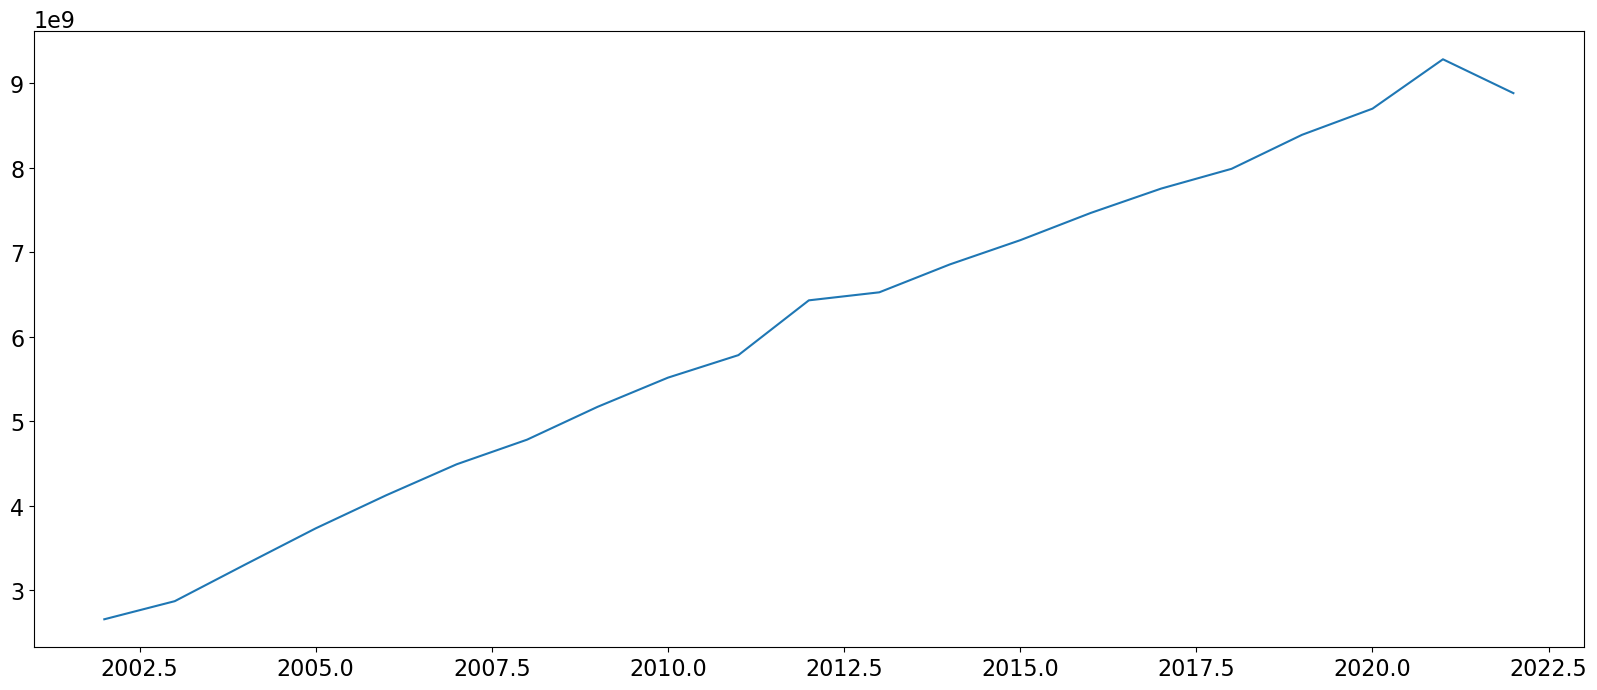

In [28]:
plt.plot(varTable.groupby("year")["equity"].sum())

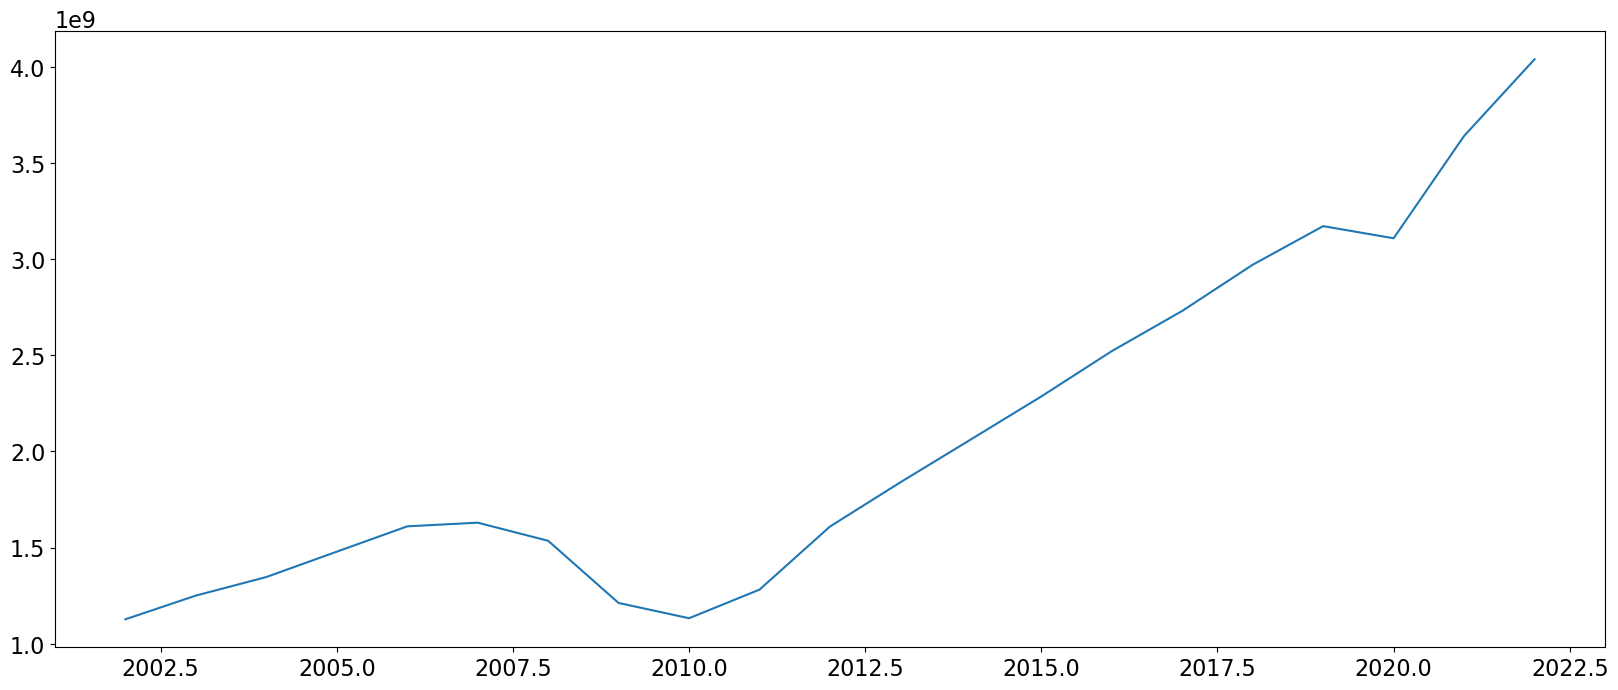

In [29]:
plt.plot(varTable.groupby("year")["reserveUndividedProfit"].sum())

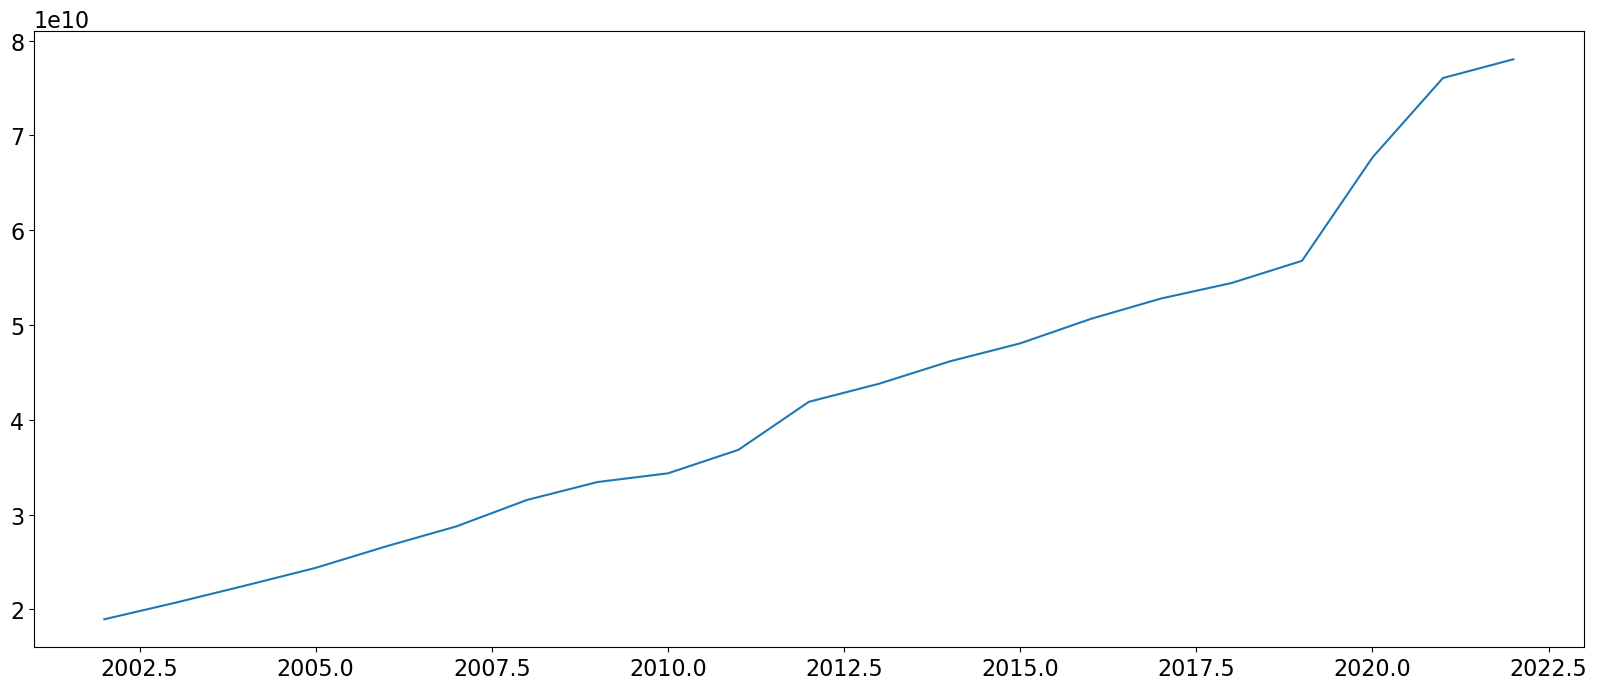

In [15]:
plt.plot(varTable.groupby("year")["deposit"].sum())

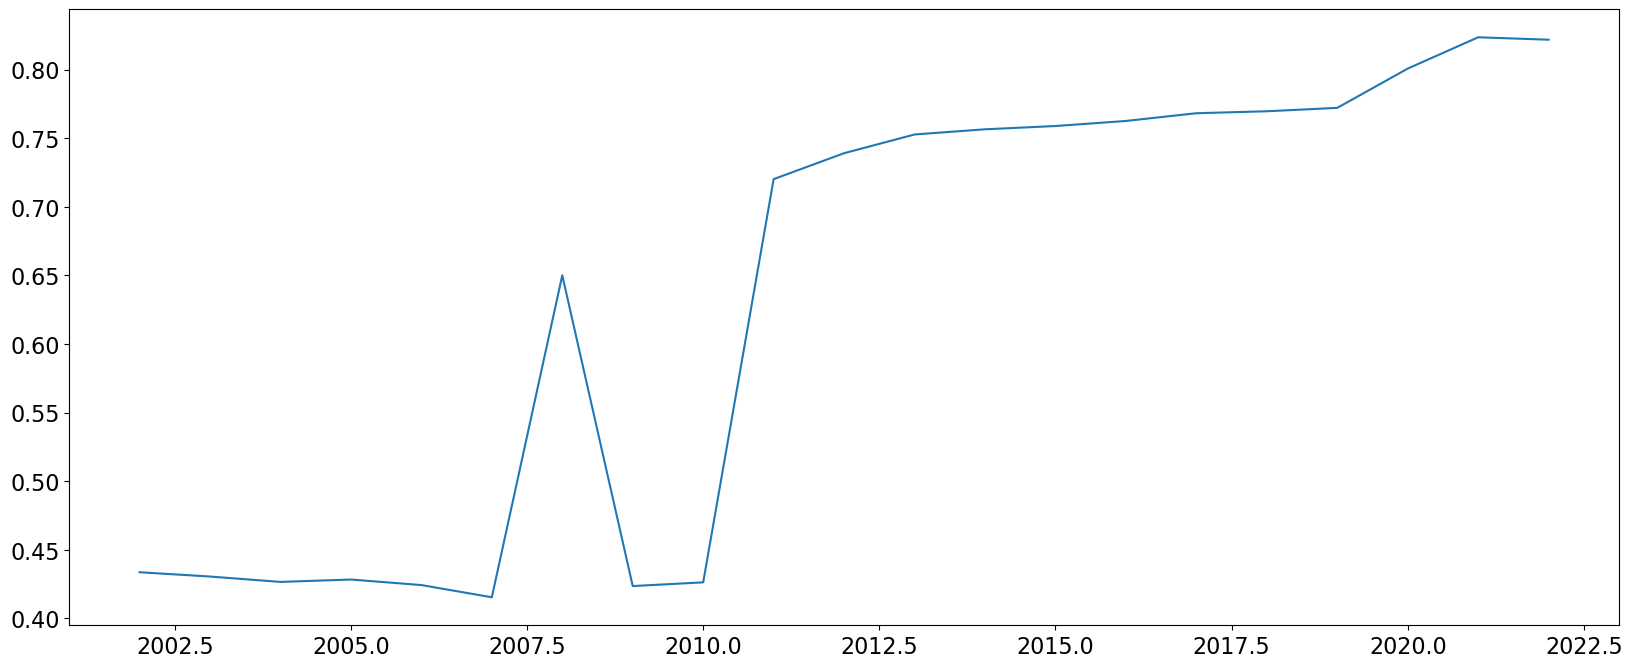

In [16]:
plt.plot(varTable.groupby("year")["deposit"].sum() / varTable.groupby("year")["assets"].sum(), label = "deposit/liabilities")

<AxesSubplot:xlabel='year'>

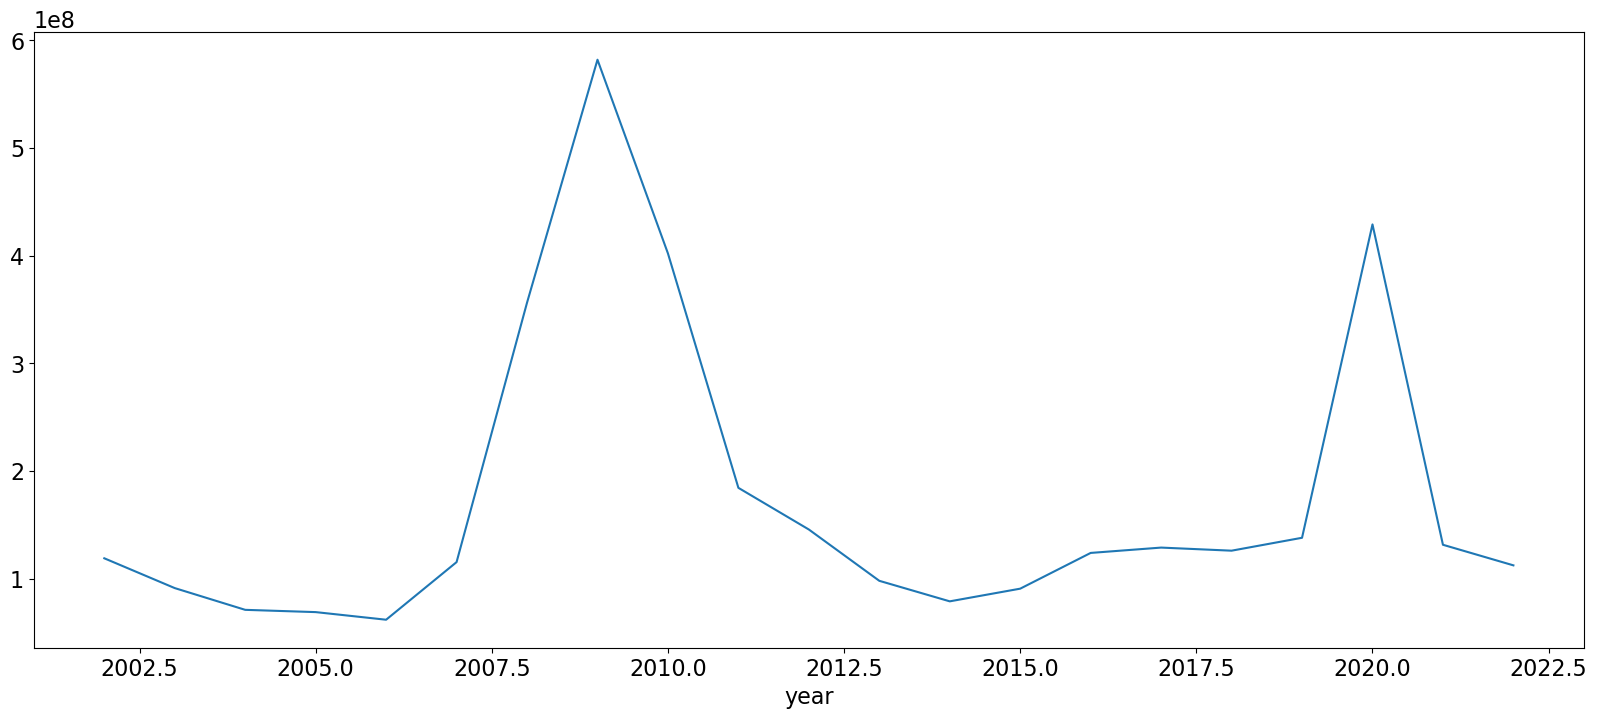

In [17]:
varTable["provision"].abs().groupby(varTable["year"]).sum().plot()

In [18]:
def bigVsSmall(varTable, varName):
    bigs = []
    smalls = []
    for year in range(2002, 2023):
        big20 = varTable.groupby("bank")["assets"].sum().sort_values(ascending = False).head(20).index.values
        big = varTable[(varTable.date.dt.year == year)& varTable["bank"].isin(big20)][varName].mean()
        small = varTable[(varTable.date.dt.year == year)& ~varTable["bank"].isin(big20)][varName].mean()
        bigs.append(big)
        smalls.append(small)
    plt.plot(range(2002, 2023),bigs, label = "large banks")
    plt.plot(range(2002, 2023),smalls, label = "small banks")
    plt.xticks(range(2002, 2023))
    plt.legend()

In [19]:
def bigVsSmallRatio(varTable, varName1, varName2):
    bigs = []
    smalls = []
    for year in range(2002, 2023):
        big20 = varTable.groupby("bank")["assets"].sum().sort_values(ascending = False).head(20).index.values
        big = varTable[(varTable.date.dt.year == year)& varTable["bank"].isin(big20)][varName1].sum()/varTable[(varTable.date.dt.year == year)& varTable["bank"].isin(big20)][varName2].sum()
        small = varTable[(varTable.date.dt.year == year)& ~varTable["bank"].isin(big20)][varName1].sum()/varTable[(varTable.date.dt.year == year)& ~varTable["bank"].isin(big20)][varName2].sum()
        bigs.append(big)
        smalls.append(small)
    plt.plot(range(2002, 2023),bigs, label = "large banks")
    plt.plot(range(2002, 2023),smalls, label = "small banks")
    plt.xticks(range(2002, 2023))
    plt.xlabel("year")
    plt.ylabel("ratio")
    plt.legend()

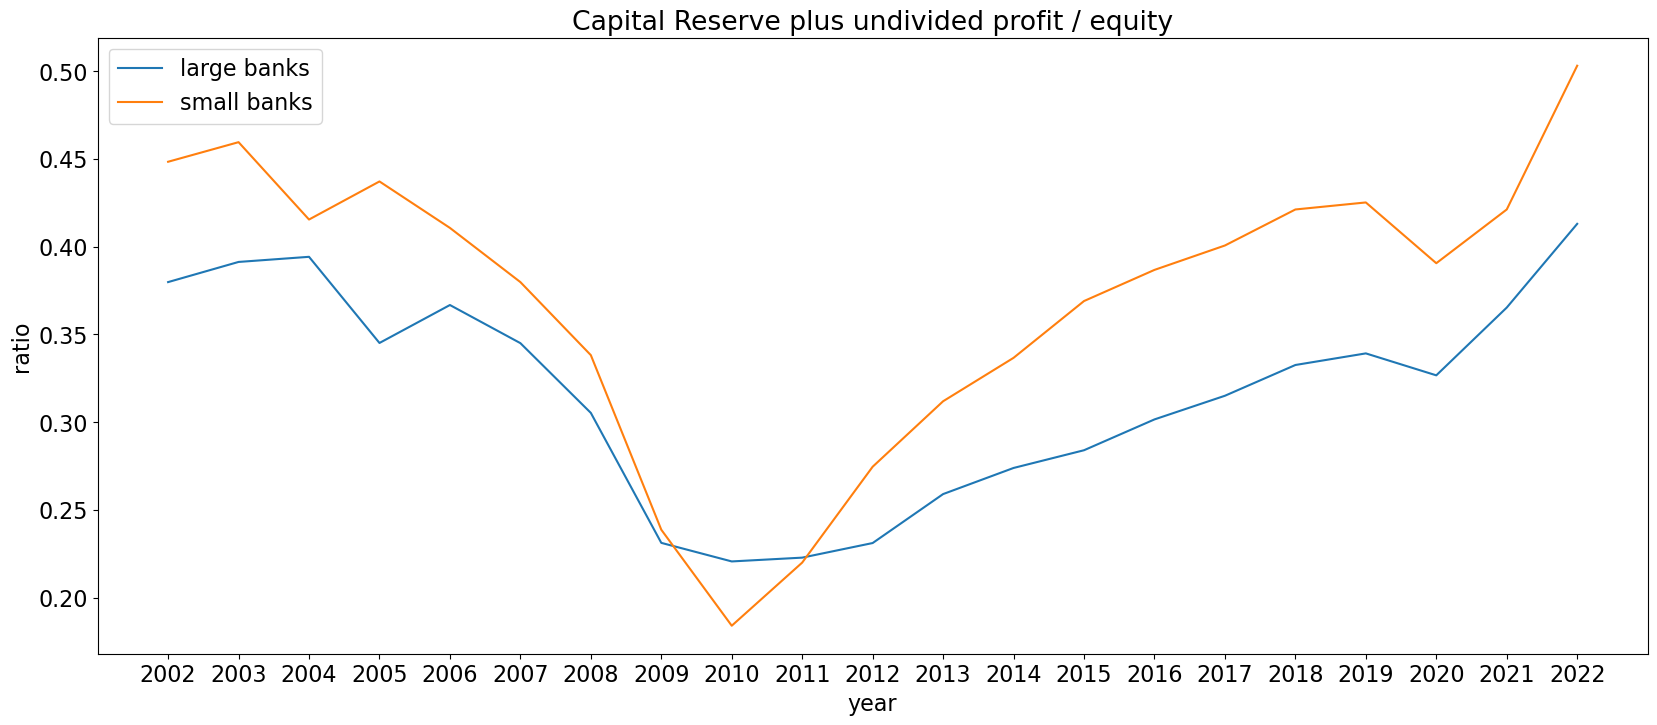

In [37]:
plt.title("Capital Reserve plus undivided profit / equity")
bigVsSmallRatio(varTable, "reserveUndividedProfit", "equity")

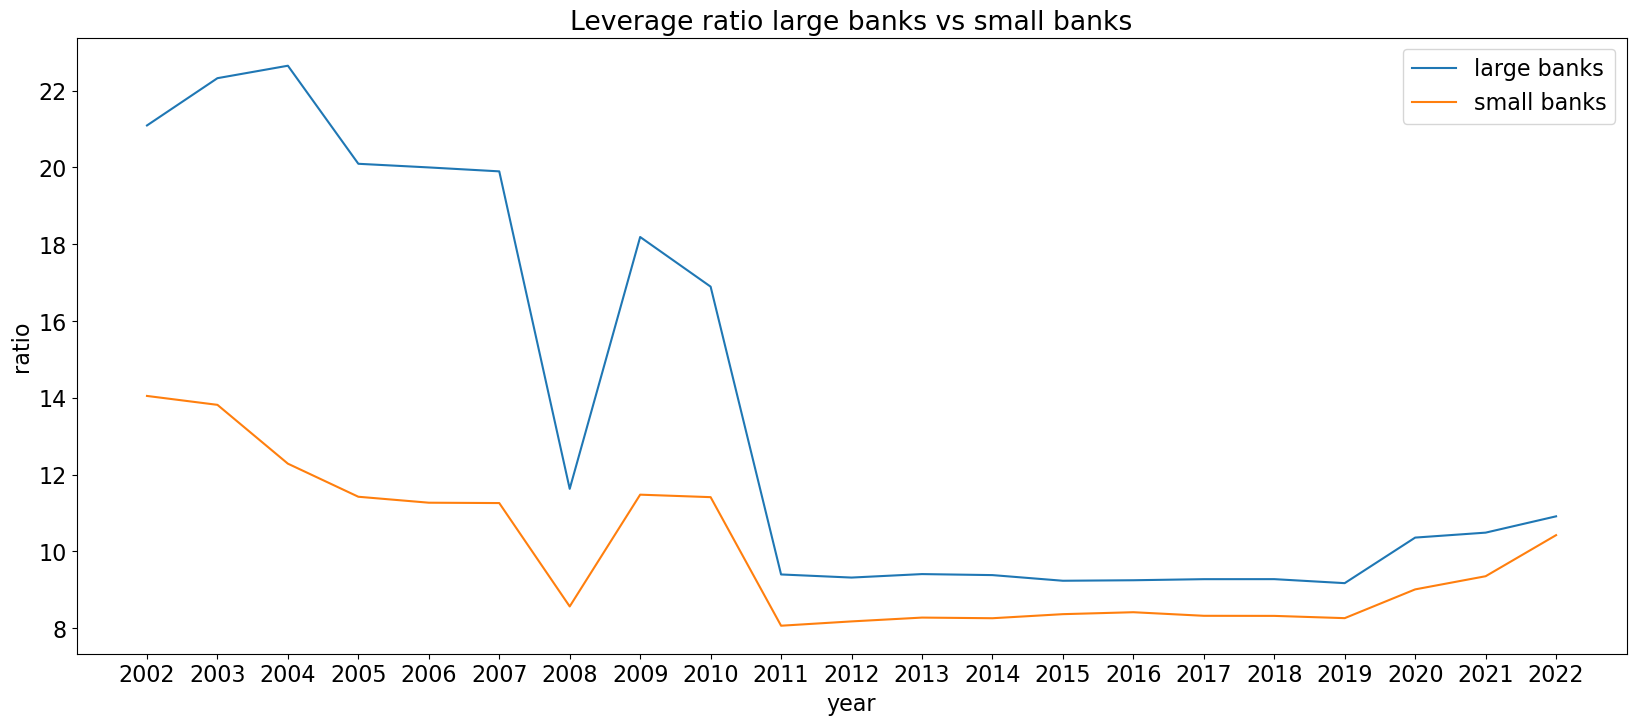

In [20]:
plt.title("Leverage ratio large banks vs small banks")
bigVsSmallRatio(varTable, "assets", "equity")

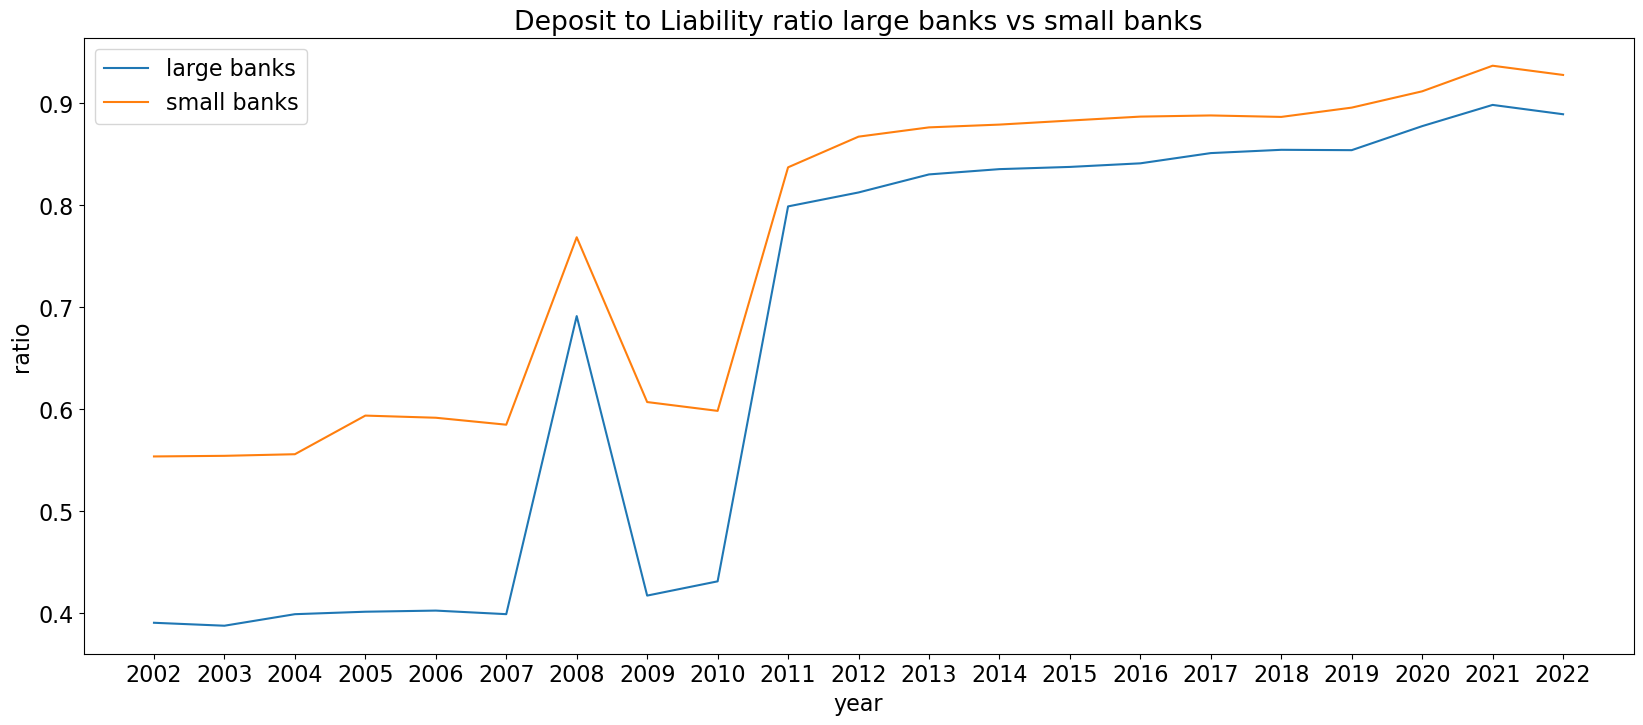

In [21]:
plt.title("Deposit to Liability ratio large banks vs small banks")
bigVsSmallRatio(varTable, "deposit", "liabilities")

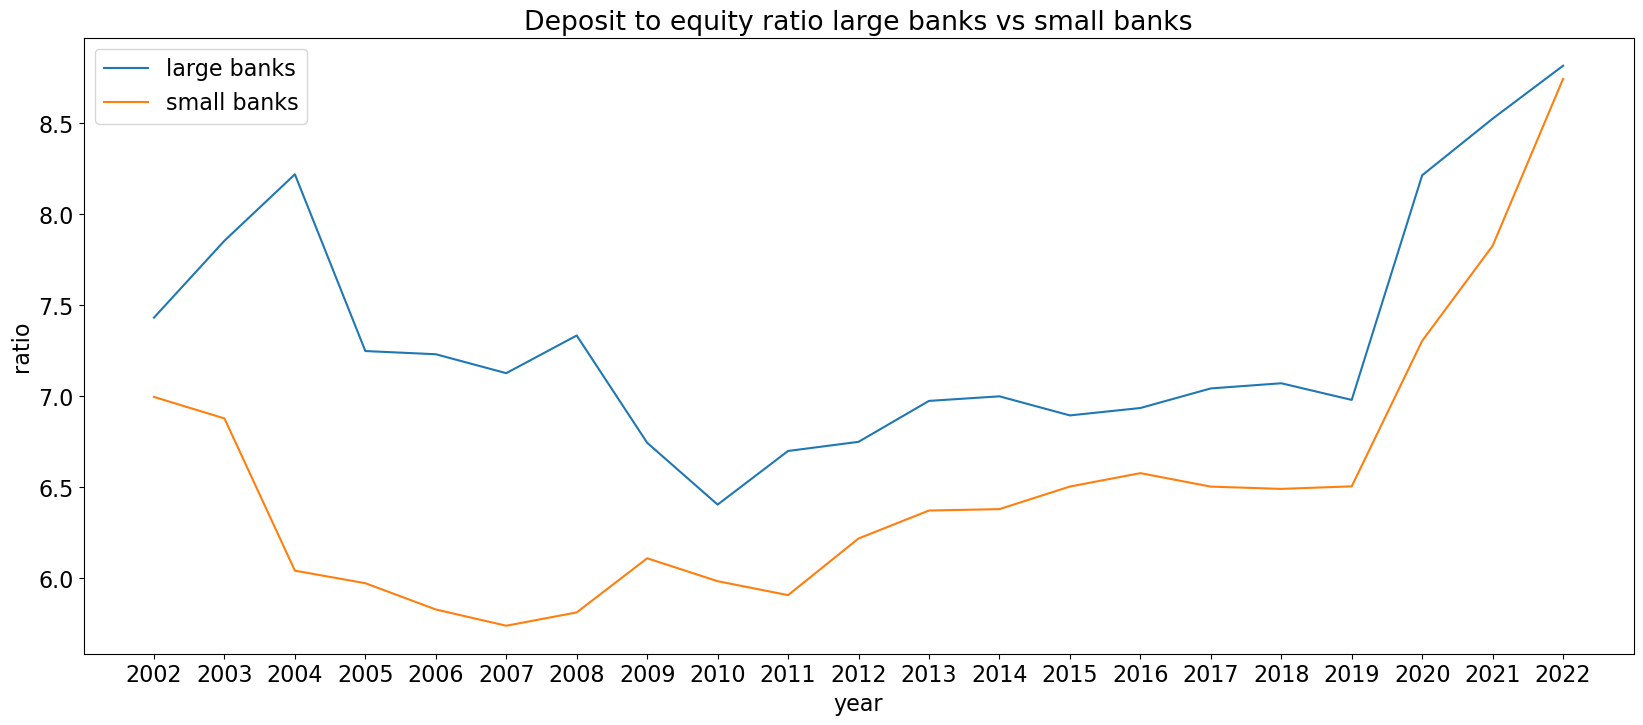

In [22]:
plt.title("Deposit to equity ratio large banks vs small banks")
bigVsSmallRatio(varTable, "deposit", "equity")

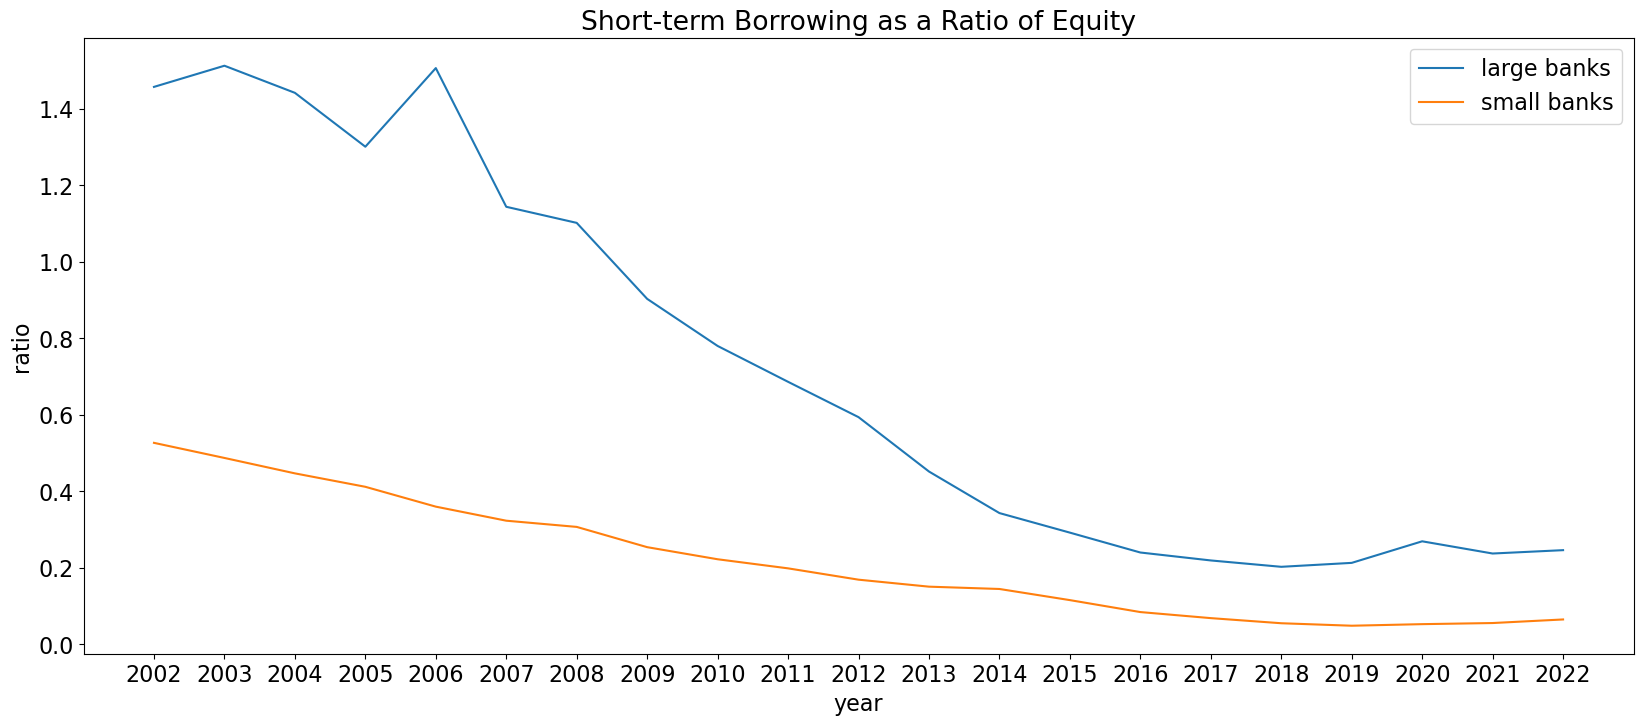

In [23]:
plt.title("Short-term Borrowing as a Ratio of Equity")
bigVsSmallRatio(varTable, "shortBorrowing", "equity")

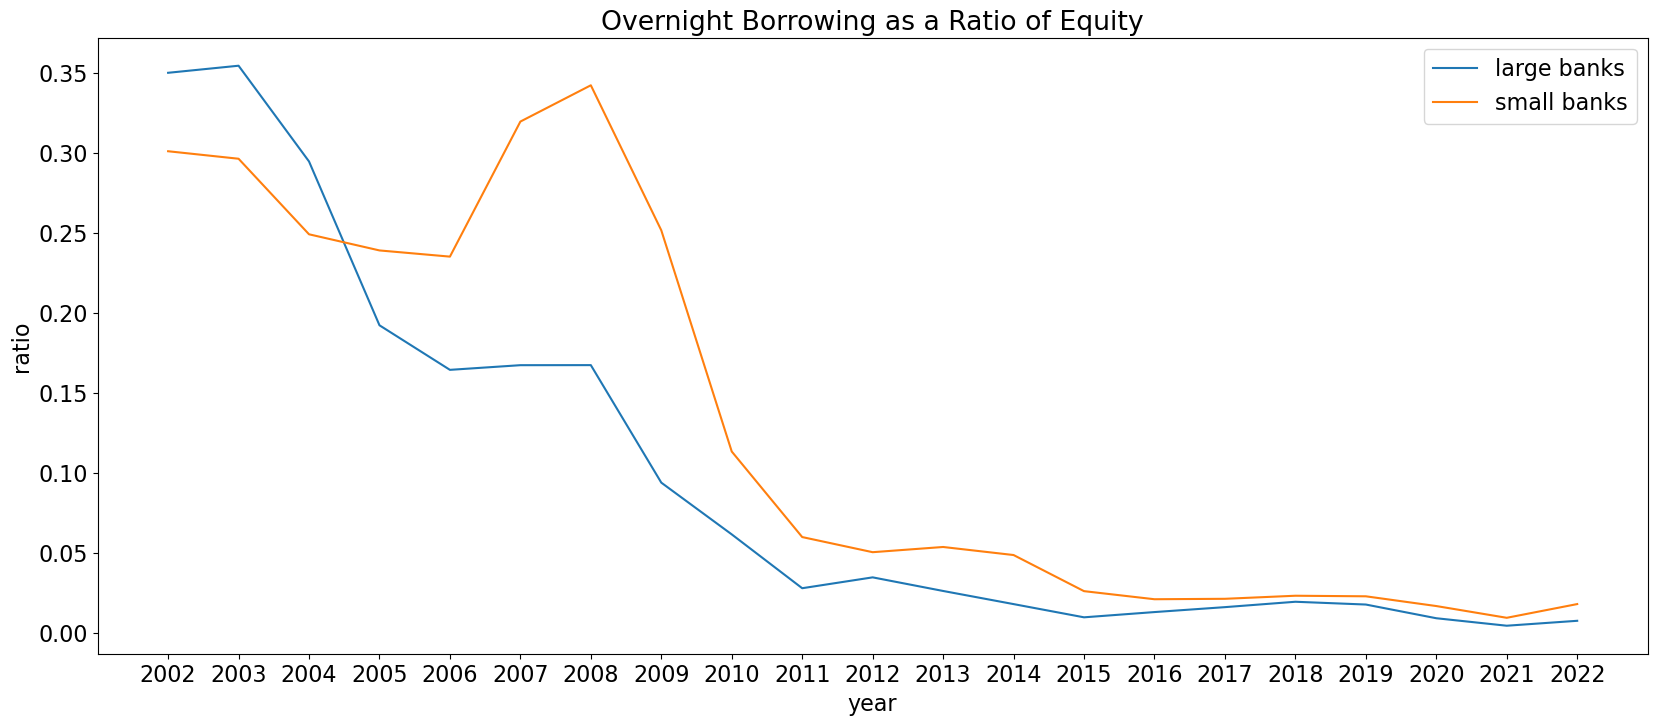

In [24]:
plt.title("Overnight Borrowing as a Ratio of Equity")
bigVsSmallRatio(varTable, "overnightBorrowing", "equity")


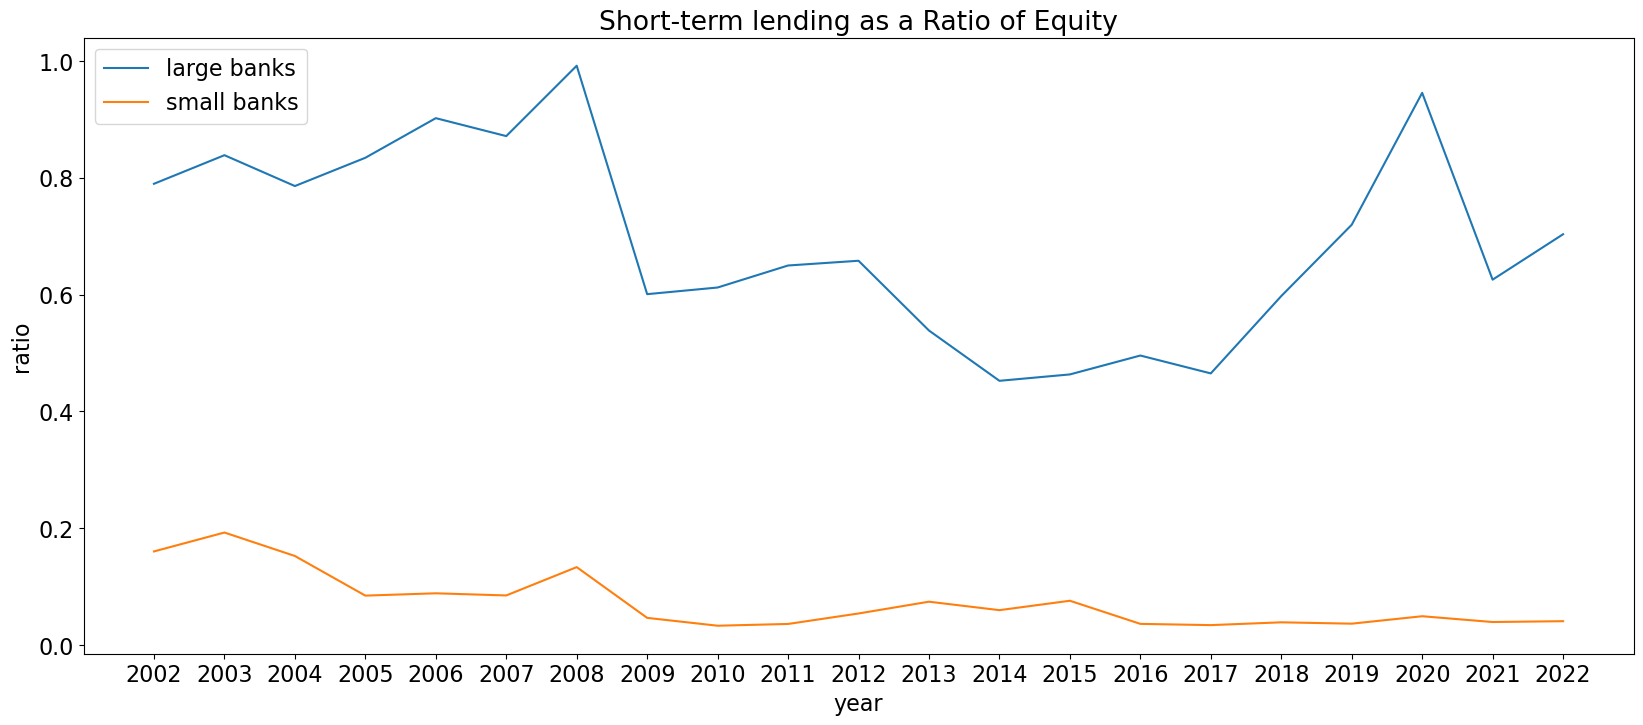

In [25]:
plt.title("Short-term lending as a Ratio of Equity")
bigVsSmallRatio(varTable, "shortLending", "equity")

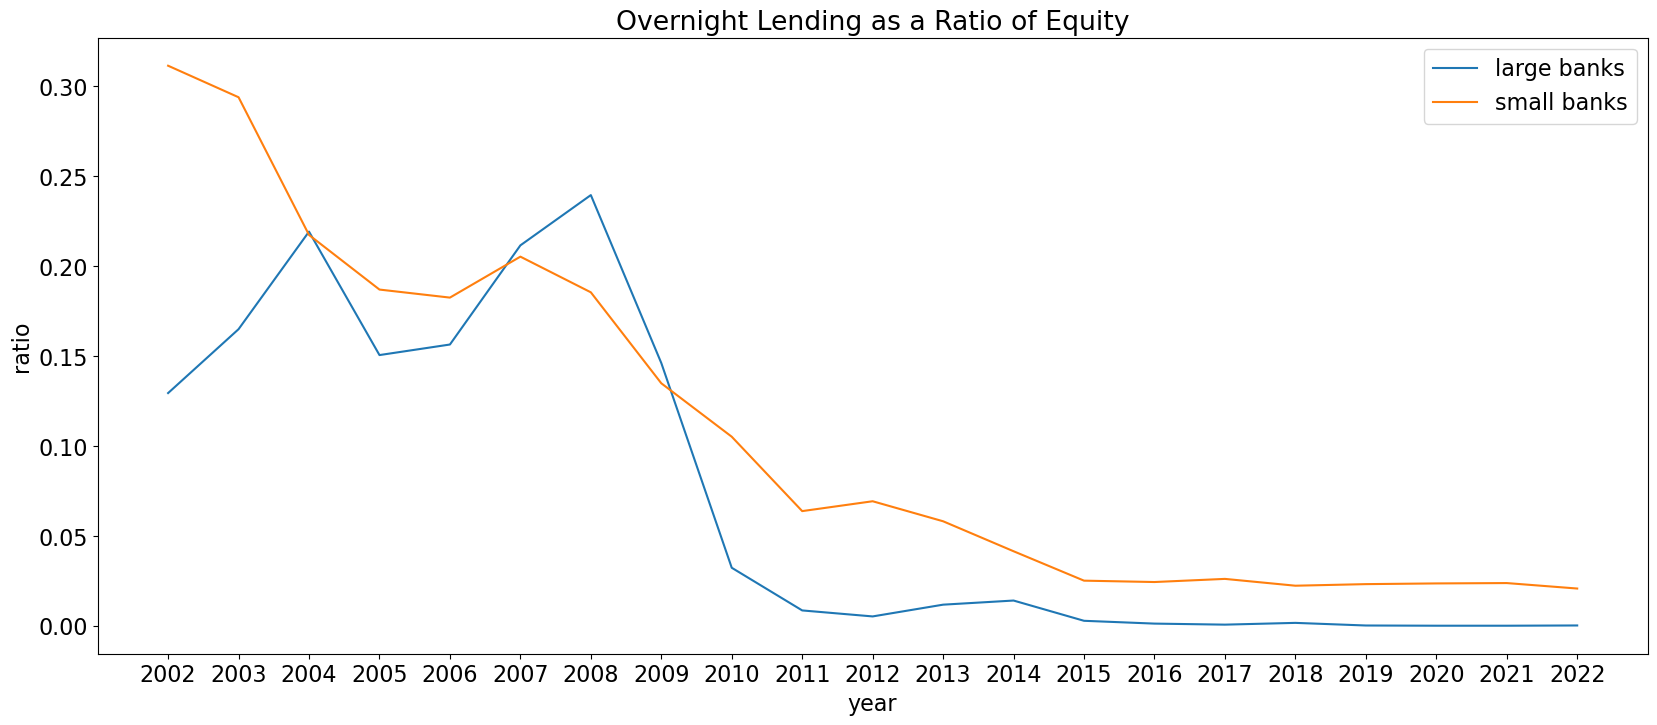

In [26]:
plt.title("Overnight Lending as a Ratio of Equity")
bigVsSmallRatio(varTable, "overnightLending", "equity")

In [27]:
# df = varYear[varYear.date == "2022-03-31"].groupby("bank").mean()
# df = df.sort_values("assets", ascending = False).reset_index()
# df.to_csv("banksData_2022.csv")